In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from datetime import date, timedelta
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN

In [2]:
#setting a random set
tf.random.set_seed(1234)

In [3]:
#reading the dataset
df_active = pd.read_csv('daily_cases.csv')
df_active.set_index('date',inplace = True)
df_active.index=pd.to_datetime(df_active.index)
df_active

,active
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2022-04-26,5399
2022-04-27,3303
2022-04-28,3377


In [4]:
df_active.describe()

,active
count,830.000000
mean,51902.636145
std,80328.599272
min,0.000000
25%,7560.250000
50%,24292.500000
75%,53429.250000
max,414188.000000


In [5]:
print(df_active.skew())
print(df_active.kurt())
print(df_active.median())

active    2.658847
dtype: float64
active    6.823973
dtype: float64
active    24292.5
dtype: float64


In [6]:
#defining a function to plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Daily Cases)', {'fontsize': 12})

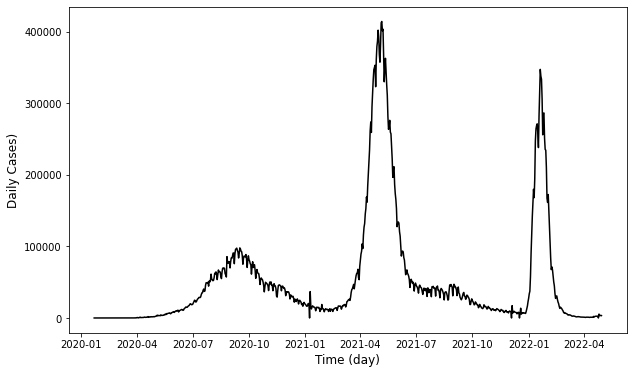

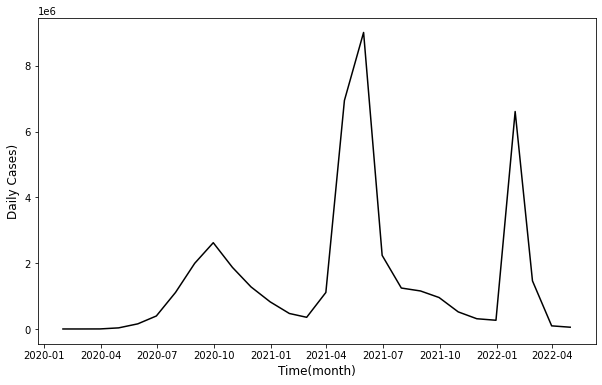

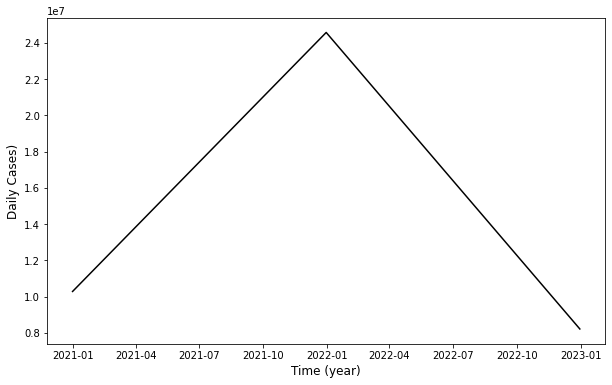

In [7]:
#analysing the data daily, monthly and yearly
dataset = df_active.copy()
timeseries(df_active.index, dataset['active'], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['active'], 'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['active'], 'Time (year)')

In [8]:
# Split train data(80%) and test data(20%)
train_size = int(len(df_active)*0.8)
train_data = df_active.iloc[:train_size]
test_data = df_active.iloc[train_size:]

In [9]:
len(train_data),len(test_data)

(664, 166)

In [10]:
##scale or normalize data as the data is too skewed
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [11]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)

Now

1). X_train - This includes your all independent variables,these will be used to train the model, also as we have specified the test_size = 0.2, this means 80% of observations from your complete data will be used to train/fit the model and rest 20% will be used to test the model.

2). X_test - This is remaining 20% portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.

3). y_train - This is your dependent variable which needs to be predicted by this model, this includes category labels against your independent variables, we need to specify our dependent variable while training/fitting the model.

4). y_test - This data has category labels for your test data, these labels will be used to test the accuracy between actual and predicted categories.

In [12]:
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (634, 30, 1)
y_train.shape:  (634, 1)
X_test.shape:  (136, 30, 1)
y_test.shape:  (136, 1)


In [13]:
# Create RNN model
def create_rnn(units):
    model = Sequential()
    # Input layer
    model.add(SimpleRNN (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(SimpleRNN(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_rnn = create_rnn(64)

In [14]:
# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_lstm = create_lstm(64)

In [15]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True, activation='relu'), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='relu'))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [16]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [17]:
# training the models
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history


In [18]:
history_rnn = fit_model(model_rnn)

Epoch 1/100
32/32 [==============================] - 7s 55ms/step - loss: 0.0098 - val_loss: 5.2115e-04
Epoch 2/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0056 - val_loss: 8.1693e-04
Epoch 3/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 6/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 8/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 9/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0055 - val_loss: 9.6177e-04
Epoch 10/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0030 - val_

In [19]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
32/32 [==============================] - 8s 77ms/step - loss: 0.0636 - val_loss: 0.0036
Epoch 2/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0198 - val_loss: 0.0043
Epoch 3/100
32/32 [==============================] - 2s 52ms/step - loss: 0.0781 - val_loss: 0.0037
Epoch 4/100
32/32 [==============================] - 2s 52ms/step - loss: 0.0517 - val_loss: 0.0011
Epoch 5/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0321 - val_loss: 0.0057
Epoch 6/100
32/32 [==============================] - 2s 52ms/step - loss: 0.0168 - val_loss: 0.0024
Epoch 7/100
32/32 [==============================] - 2s 52ms/step - loss: 0.0147 - val_loss: 3.2629e-04
Epoch 8/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0247 - val_loss: 0.0013
Epoch 9/100
32/32 [==============================] - 2s 52ms/step - loss: 0.0121 - val_loss: 0.0010
Epoch 10/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0096 - val_loss: 4.

In [20]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
32/32 [==============================] - 29s 223ms/step - loss: 0.0636 - val_loss: 0.0032
Epoch 2/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0260 - val_loss: 0.0047
Epoch 3/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0280 - val_loss: 0.0026
Epoch 4/100
32/32 [==============================] - 3s 83ms/step - loss: 0.0469 - val_loss: 8.5602e-04
Epoch 5/100
32/32 [==============================] - 3s 79ms/step - loss: 0.0260 - val_loss: 0.0054
Epoch 6/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0171 - val_loss: 0.0067
Epoch 7/100
32/32 [==============================] - 2s 76ms/step - loss: 0.0127 - val_loss: 0.0046
Epoch 8/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0085 - val_loss: 4.3961e-04
Epoch 9/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0097 - val_loss: 0.0068
Epoch 10/100
32/32 [==============================] - 2s 77ms/step - loss: 0.0079 - val_lo

In [21]:
history_gru = fit_model(model_gru)

Epoch 1/100
32/32 [==============================] - 8s 80ms/step - loss: 0.0650 - val_loss: 0.0054
Epoch 2/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0650 - val_loss: 0.0044
Epoch 3/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0292 - val_loss: 0.0066
Epoch 4/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0141 - val_loss: 0.0034
Epoch 5/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 6/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0188 - val_loss: 0.0096
Epoch 7/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0080 - val_loss: 2.5188e-04
Epoch 8/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0036 - val_loss: 1.5024e-04
Epoch 9/100
32/32 [==============================] - 2s 56ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0026 - val_loss

In [22]:
#inverse transform
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

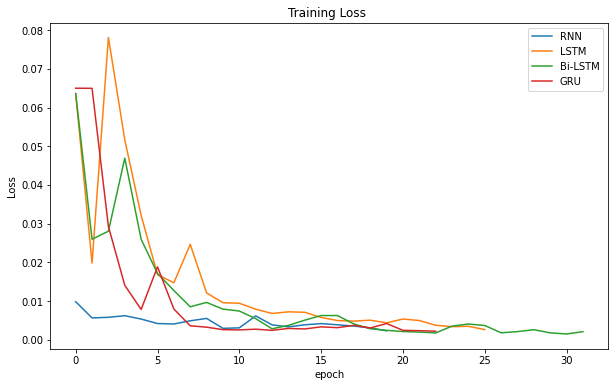

In [23]:
#plotting the training loss for each model
plt.figure(figsize = (10, 6))
plt.plot(history_rnn.history['loss'])
plt.plot(history_lstm.history['loss'])
plt.plot(history_bilstm.history['loss'])
plt.plot(history_gru.history['loss'])
plt.title('Training Loss ' )
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM','Bi-LSTM','GRU'], loc='upper right')

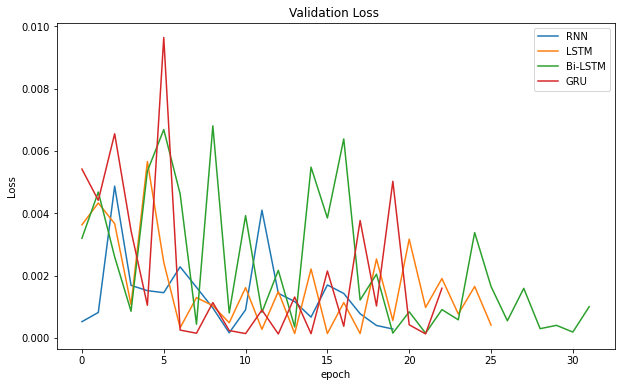

In [24]:
#plotting the validation loss
plt.figure(figsize = (10, 6))
plt.plot(history_rnn.history['val_loss'])
plt.plot(history_lstm.history['val_loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Validation Loss ' )
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM','Bi-LSTM','GRU'], loc='upper right')

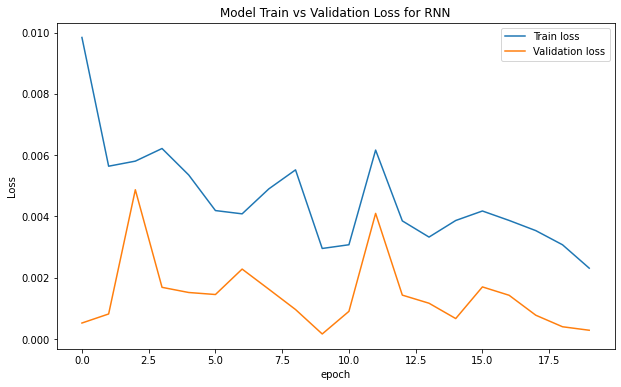

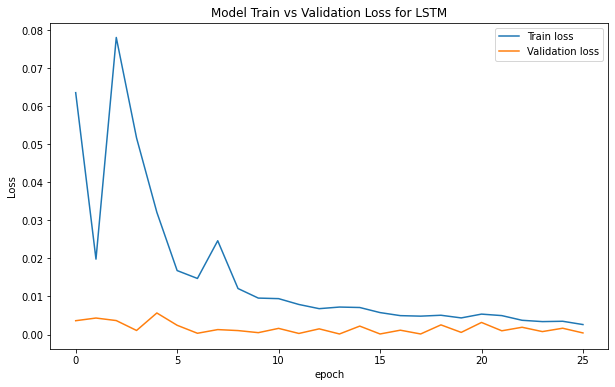

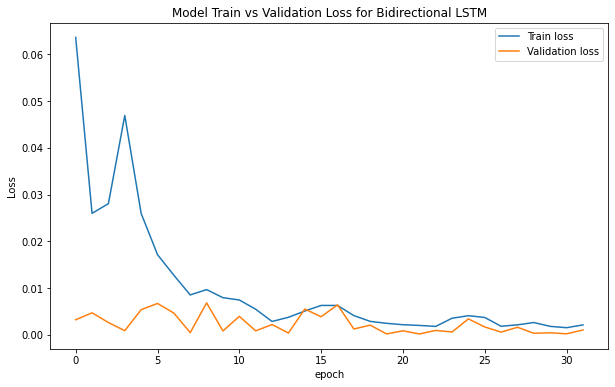

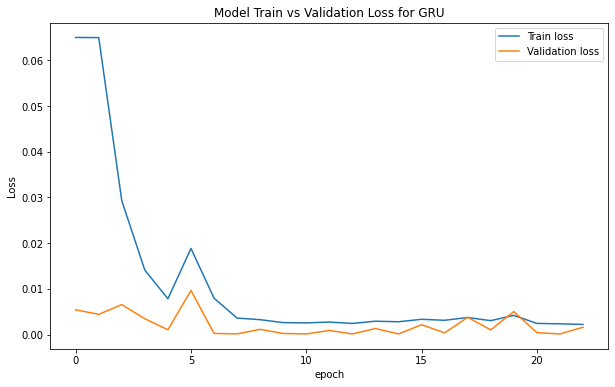

In [25]:
#function to plot the training loss and validation loss
#The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
#plotting the loss
plot_loss (history_rnn, 'RNN')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_bilstm, 'Bidirectional LSTM')
plot_loss (history_gru, 'GRU')

In [26]:
# predicting dataset function
def prediction(model, data):
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

#prediciting train dataset
modeling_rnn = prediction(model_rnn, X_train)
modeling_lstm = prediction(model_lstm, X_train)
modeling_bilstm = prediction(model_bilstm, X_train)
modeling_gru = prediction(model_gru, X_train)

#predicting test dataset
prediction_rnn = prediction(model_rnn, X_test)
prediction_lstm = prediction(model_lstm, X_test)
prediction_bilstm = prediction(model_bilstm, X_test)
prediction_gru = prediction(model_gru, X_test)

5/5 [==============================] - 0s 15ms/step


Text(0, 0.5, 'Total Daily Cases')

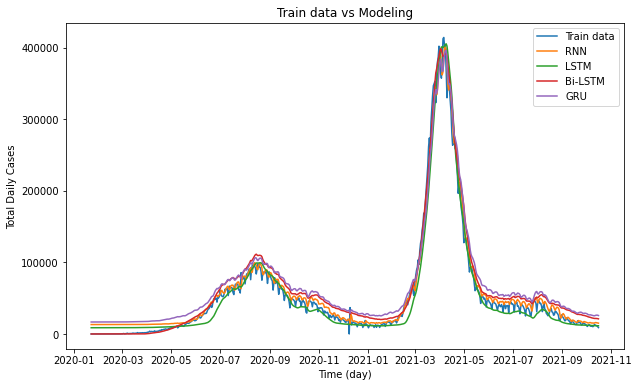

In [27]:
# Plot train data vs modeling
plt.figure(figsize=(10, 6))
range_future = df_active.index[:len(X_train)]
plt.plot(range_future, np.array(y_train),label='Train data')
plt.plot(range_future, np.array(modeling_rnn),label='RNN')
plt.plot(range_future, np.array(modeling_lstm),label='LSTM')
plt.plot(range_future, np.array(modeling_bilstm),label='Bi-LSTM')
plt.plot(range_future, np.array(modeling_gru),label='GRU')
plt.title('Train data vs Modeling')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Cases')

Text(0, 0.5, 'Total Daily Cases')

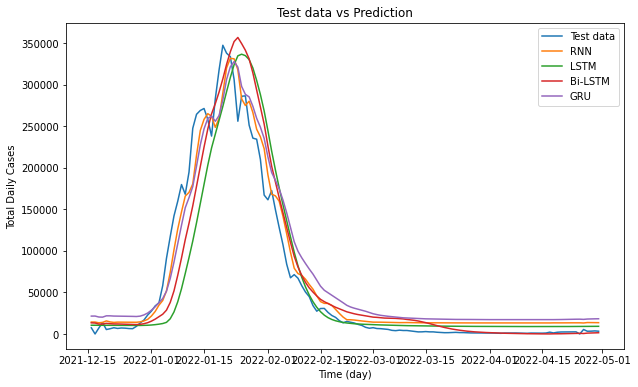

In [28]:
# Plot test data vs prediction
plt.figure(figsize=(10, 6))
range_future = df_active.index[len(X_train)+60:]
plt.plot(range_future, np.array(y_test), label='Test data')
plt.plot(range_future, np.array(prediction_rnn),label='RNN')
plt.plot(range_future, np.array(prediction_lstm),label='LSTM')
plt.plot(range_future, np.array(prediction_bilstm),label='Bi-LSTM')
plt.plot(range_future, np.array(prediction_gru),label='GRU')
plt.title('Test data vs Prediction')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Cases')

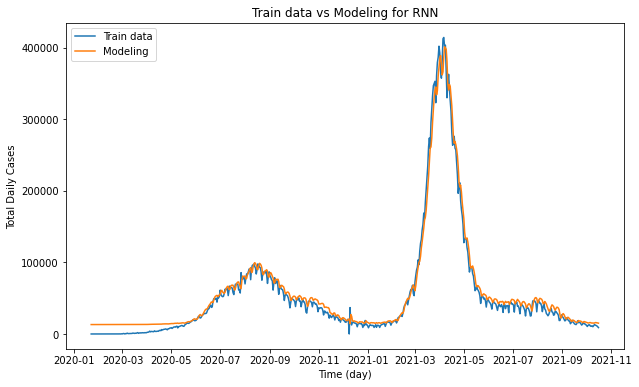

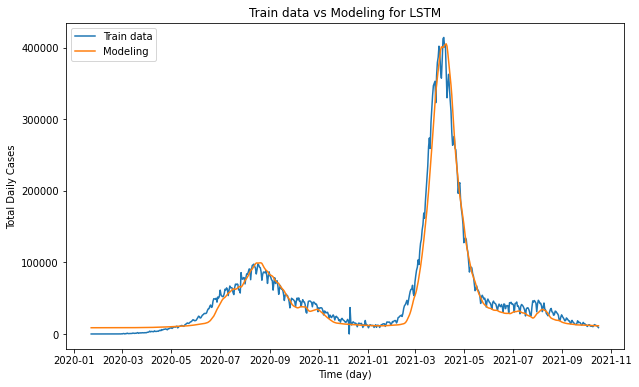

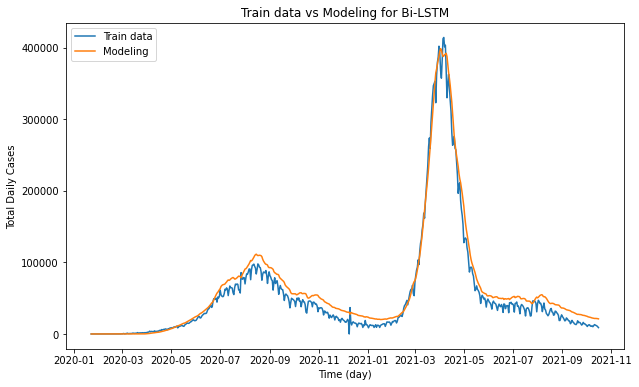

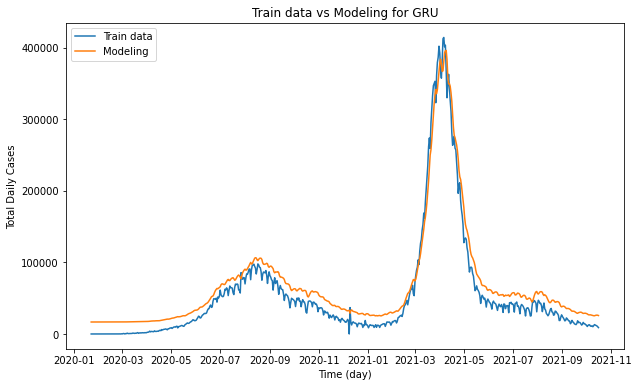

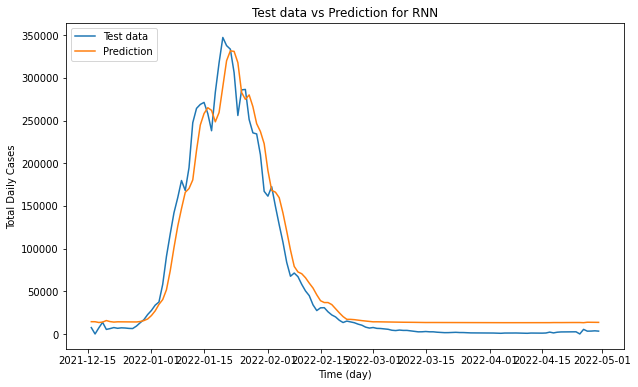

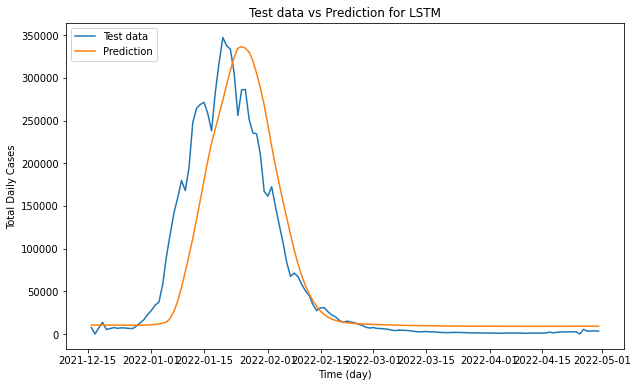

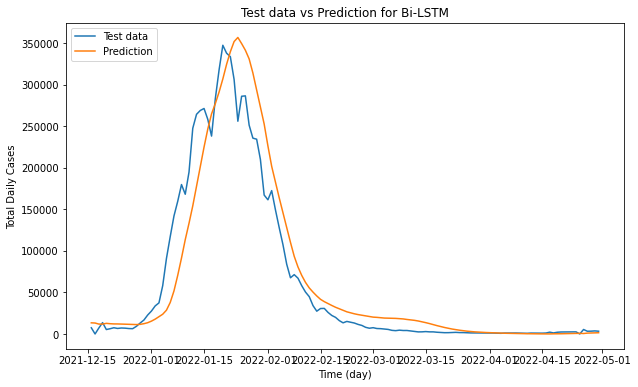

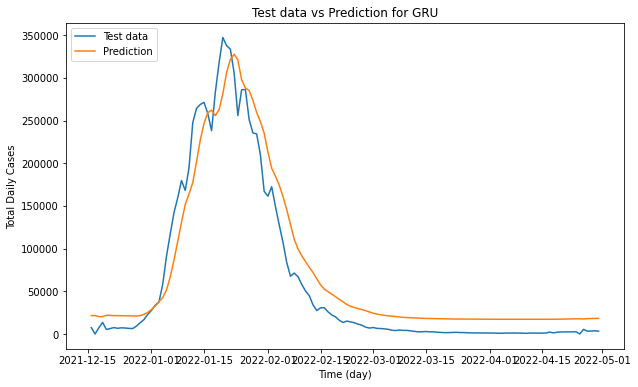

In [29]:
# Plot train/test data vs modeling/prediction 
def plot_model(modeling, model_name, data, d_name, p_name ):
    
    if d_name == 'Train data':
        range_future = df_active.index[:len(modeling)]
    else:
        range_future = df_active.index[len(df_active)-len(modeling):]        
    
    plt.figure(figsize=(10, 6))
    plt.plot(range_future, np.array(data), label= d_name)
    plt.plot(range_future, np.array(modeling),label= p_name)
    plt.title(d_name + ' vs '+ p_name + ' for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Total Daily Cases')

#plotting train data
plot_model(modeling_rnn, 'RNN', y_train, 'Train data', 'Modeling')
plot_model(modeling_lstm, 'LSTM', y_train, 'Train data', 'Modeling')
plot_model(modeling_bilstm, 'Bi-LSTM', y_train, 'Train data', 'Modeling')
plot_model(modeling_gru, 'GRU', y_train, 'Train data', 'Modeling')

#plotting test data
plot_model(prediction_rnn, 'RNN', y_test, 'Test data', 'Prediction')
plot_model(prediction_lstm, 'LSTM', y_test, 'Test data', 'Prediction')
plot_model(prediction_bilstm, 'Bi-LSTM', y_test, 'Test data', 'Prediction')
plot_model(prediction_gru, 'GRU', y_test, 'Test data', 'Prediction')

In [30]:
# from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
# def evaluate_prediction(predictions, actual, model_name):
#   global mse, rmse, mae, mda, ev, mape
#   errors = predictions - actual
#   #m=(abs(predictions)+abs(actual))/2
#   mse = np.square(errors).mean()
#   rmse = np.sqrt(mse)
#   mae = np.abs(errors).mean()
#   mda = np.mean((np.sign(actual[1:] - actual[:-1])==np.sign(predictions[1:] - predictions[:-1])).astype(int))
#   ev = explained_variance_score(actual, predictions)
#   #mape = mean_absolute_percentage_error(actual, predictions)
#   #smape= np.mean(errors/m)
#   print(model_name + ':')
#   print('Mean Absolute Error: {:.4f}'.format(mae))
#   print('Mean Square Error: {:.4f}'.format(mse))
#   print('Root Mean Square Error: {:.4f}'.format(rmse))
#   print('Mean Directional Accuracy: {:.4f}'.format(mda))
#   print('Explained Variance Score: {:.4f}'.format(ev))
#   # the value when some element of the y_true is zero is arbitrarily high because of the division by epsilon
#   #print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
#   print('')

# evaluate_prediction(prediction_rnn, y_test, 'Simple RNN')
# E1=[mae,mse,rmse,mda,ev]
# evaluate_prediction(prediction_lstm, y_test, 'LSTM')
# E2=[mae,mse,rmse,mda,ev]
# evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
# E3=[mae,mse,rmse,mda,ev]
# evaluate_prediction(prediction_gru, y_test, 'GRU')
# E4=[mae,mse,rmse,mda,ev]

In [31]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

def evaluate_prediction(predictions, actual, model_name):
  global mse, rmse, mae, mda, ev, mape
  errors = predictions - actual
  #m=(abs(predictions)+abs(actual))/2
  mse = mean_squared_error(actual,predictions)
  rmse = mean_squared_error(actual, predictions, squared = False)
  mae = mean_absolute_error(actual, predictions)
  mda = np.mean((np.sign(actual[1:] - actual[:-1])==np.sign(predictions[1:] - predictions[:-1])).astype(int))
  ev = explained_variance_score(actual, predictions)
  #mape = mean_absolute_percentage_error(actual, predictions)
  #smape= np.mean(errors/m)
  print(model_name + ':')
  print('Mean Absolute Error: {:.4f}'.format(mae))
  print('Mean Square Error: {:.4f}'.format(mse))
  print('Root Mean Square Error: {:.4f}'.format(rmse))
  print('Mean Directional Accuracy: {:.4f}'.format(mda))
  print('Explained Variance Score: {:.4f}'.format(ev))
  # the value when some element of the y_true is zero is arbitrarily high because of the division by epsilon
  #print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
  print('')

evaluate_prediction(prediction_rnn, y_test, 'Simple RNN')
E1=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
E2=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
E3=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_gru, y_test, 'GRU')
E4=[mae,mse,rmse,mda,ev]

Simple RNN:
Mean Absolute Error: 14769.1728
Mean Square Error: 377218612.5154
Root Mean Square Error: 19422.1166
Mean Directional Accuracy: 0.6370
Explained Variance Score: 0.9642

LSTM:
Mean Absolute Error: 23723.9238
Mean Square Error: 1674796936.6155
Root Mean Square Error: 40924.2830
Mean Directional Accuracy: 0.6963
Explained Variance Score: 0.8247

Bidirectional LSTM:
Mean Absolute Error: 19186.0833
Mean Square Error: 998413949.6146
Root Mean Square Error: 31597.6890
Mean Directional Accuracy: 0.6741
Explained Variance Score: 0.8969

GRU:
Mean Absolute Error: 22599.5029
Mean Square Error: 729352014.6319
Root Mean Square Error: 27006.5180
Mean Directional Accuracy: 0.6519
Explained Variance Score: 0.9395



In [32]:
# #pip install sktime --user
# import sktime
# from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
# mase = MeanAbsoluteScaledError()
# print(mase(y_test,prediction_rnn,y_train = y_train))

In [33]:
# from sklearn.metrics import mean_absolute_error
# def mean_absolute_scaled_error(y_true, y_pred, y_train):
#     e_t = y_true - y_pred
#     scale = mean_absolute_error(y_train[1:], y_train[:-1])
#     return np.mean(np.abs(e_t / scale))

# print(mean_absolute_scaled_error(y_test, prediction_rnn, y_train))

In [54]:
data_dict={'Model': ['RNN', 'LSTM', 'BiLSTM', 'GRU'],
             'mae': [E1[0],E2[0],E3[0],E4[0]],
             'mse': [E1[1],E2[1],E3[1],E4[1]],
           'rmse':[E1[2],E2[2],E3[2],E4[2]],
           'mda':[E1[3],E2[3],E3[3],E4[3]],
           'ev':[E1[4],E2[4],E3[4],E4[4]]}
           #'mape':[E1[5],E2[5],E3[5],E4[5]]}

In [55]:
a=pd.DataFrame(data=data_dict)
a

,Model,mae,mse,rmse,mda,ev
0,RNN,14769.172773,3.772186e+08,19422.116582,0.637037,0.964233
1,LSTM,23723.923792,1.674797e+09,40924.282970,0.696296,0.824674
2,BiLSTM,19186.083323,9.984139e+08,31597.688992,0.674074,0.896885
3,GRU,22599.502901,7.293520e+08,27006.518003,0.651852,0.939496


In [36]:
#creating dataset for forecasting
def create_dataset (X, look_back, n):
    Xs = []
    for i in range(n): #put the number of days to predict
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

In [37]:
# function for forecasting new data
def forecasted(model,model_name, new_data):
    forecasted = model.predict(new_data)
    forecasted = scaler.inverse_transform(forecasted)
    print("Forecasted for",model_name,":")
    print(forecasted)
    return forecasted

In [38]:
#Forecasting 1 day cases
new_data= create_dataset(test_scaled,30,1)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (1, 30, 1)
1/1 [==============================] - 0s 200ms/step
Forecasted for RNN :
[[14372.7705]]
1/1 [==============================] - 0s 241ms/step
Forecasted for LSTM :
[[10513.838]]
1/1 [==============================] - 0s 259ms/step
Forecasted for Bi-LSTM :
[[13398.261]]
1/1 [==============================] - 0s 165ms/step
Forecasted for GRU :
[[21497.775]]


In [39]:
#Forecasting 3 day cases
new_data= create_dataset(test_scaled,30,3)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

X_30.shape:  (3, 30, 1)
1/1 [==============================] - 0s 185ms/step
Forecasted for RNN :
[[14372.7705]
 [14339.501 ]
 [13451.762 ]]
1/1 [==============================] - 0s 80ms/step
Forecasted for LSTM :
[[10513.838]
 [10484.279]
 [10375.158]]
1/1 [==============================] - 0s 139ms/step
Forecasted for Bi-LSTM :
[[13398.258]
 [13185.128]
 [11900.938]]
1/1 [==============================] - 0s 177ms/step
Forecasted for GRU :
[[21497.773]
 [21554.162]
 [20397.344]]


In [40]:
#Forecasting 7 day cases
new_data= create_dataset(test_scaled,30, 7)
print('new_data.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

new_data.shape:  (7, 30, 1)
1/1 [==============================] - 0s 217ms/step
Forecasted for RNN :
[[14372.7705]
 [14339.501 ]
 [13451.762 ]
 [13926.775 ]
 [15701.695 ]
 [14486.582 ]
 [13916.069 ]]
1/1 [==============================] - 0s 195ms/step
Forecasted for LSTM :
[[10513.838]
 [10484.279]
 [10375.158]
 [10296.901]
 [10315.786]
 [10306.529]
 [10291.179]]
1/1 [==============================] - 0s 158ms/step
Forecasted for Bi-LSTM :
[[13398.258]
 [13185.128]
 [11900.938]
 [11873.582]
 [12783.123]
 [12352.082]
 [12091.741]]
1/1 [==============================] - 0s 217ms/step
Forecasted for GRU :
[[21497.773]
 [21554.162]
 [20397.344]
 [20244.443]
 [21824.941]
 [21814.41 ]
 [21531.932]]


In [48]:
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3, prediction4, n):
    
    plt.figure(figsize=(15, 6))
    
    range_history = df_active.index[len(df_active)-len(history):]
    l = []
    for x in range(1,n+1):
        l.append((df_active.index[-1] + timedelta(days=x)))
    range_future = l
    plt.plot(range_history, np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1), label='Forecasted for SimpleRNN')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for LSTM')
    plt.plot(range_future, np.array(prediction3), label='Forecasted for BiLSTM')
    plt.plot(range_future, np.array(prediction4), label='Forecasted for GRU')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Daily Cases')
    plt.title('Predicted Daily cases for the next {} days'.format(n))      

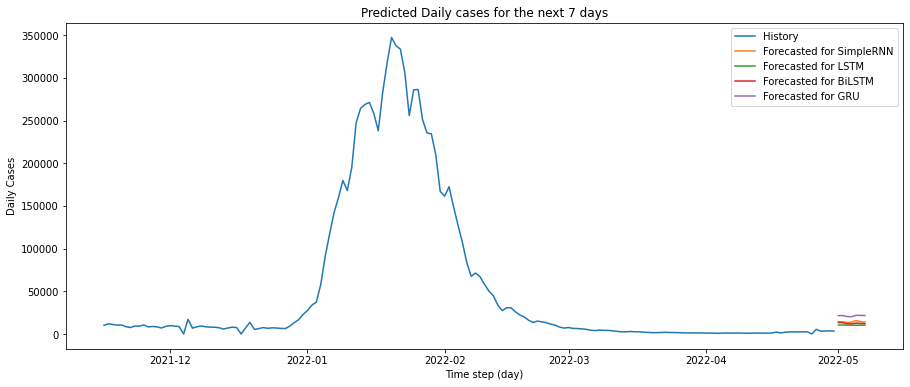

In [49]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,7)

In [50]:
#Forecasting 15 day cases
new_data= create_dataset(test_scaled,30,15)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (15, 30, 1)
1/1 [==============================] - 0s 51ms/step
Forecasted for RNN :
[[14372.7705]
 [14339.501 ]
 [13451.762 ]
 [13926.775 ]
 [15701.695 ]
 [14486.582 ]
 [13916.069 ]
 [14241.564 ]
 [14198.141 ]
 [14184.818 ]
 [14194.143 ]
 [14119.731 ]
 [14073.123 ]
 [14560.788 ]
 [15695.629 ]]
1/1 [==============================] - 0s 52ms/step
Forecasted for LSTM :
[[10513.838]
 [10484.279]
 [10375.158]
 [10296.901]
 [10315.786]
 [10306.529]
 [10291.179]
 [10285.104]
 [10276.344]
 [10271.699]
 [10268.424]
 [10259.506]
 [10246.273]
 [10262.934]
 [10343.251]]
1/1 [==============================] - 0s 59ms/step
Forecasted for Bi-LSTM :
[[13398.258]
 [13185.128]
 [11900.938]
 [11873.582]
 [12783.123]
 [12352.082]
 [12091.741]
 [12055.434]
 [11865.047]
 [11764.966]
 [11655.226]
 [11489.995]
 [11309.056]
 [11571.982]
 [12373.747]]
1/1 [==============================] - 0s 59ms/step
Forecasted for GRU :
[[21497.773]
 [21554.162]
 [20397.344]
 [20244.443]
 [21824.941]
 [21814.41

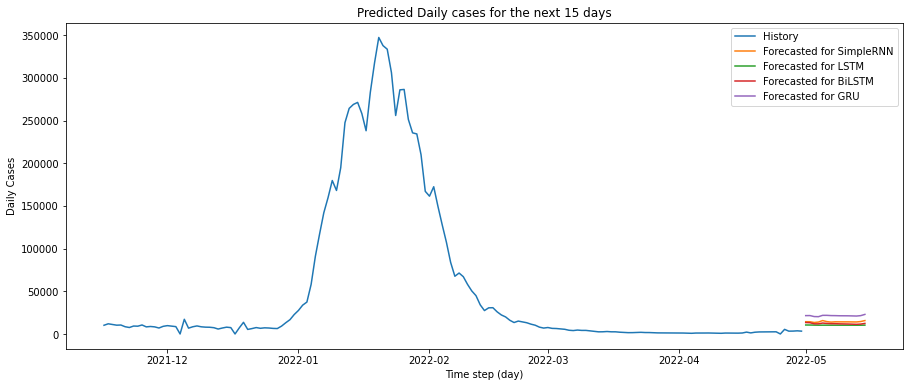

In [51]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,15)

In [52]:
#Forecasting 30 day cases
new_data= create_dataset(test_scaled,30,30)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (30, 30, 1)
1/1 [==============================] - 0s 52ms/step
Forecasted for RNN :
[[ 14372.7705]
 [ 14339.501 ]
 [ 13451.762 ]
 [ 13926.775 ]
 [ 15701.695 ]
 [ 14486.582 ]
 [ 13916.069 ]
 [ 14241.564 ]
 [ 14198.141 ]
 [ 14184.818 ]
 [ 14194.143 ]
 [ 14119.731 ]
 [ 14073.123 ]
 [ 14560.788 ]
 [ 15695.629 ]
 [ 17560.473 ]
 [ 21592.557 ]
 [ 27071.572 ]
 [ 34653.12  ]
 [ 40249.773 ]
 [ 51805.742 ]
 [ 73984.92  ]
 [101154.75  ]
 [126202.48  ]
 [146831.08  ]
 [165819.5   ]
 [170303.69  ]
 [180449.97  ]
 [214960.33  ]
 [244665.73  ]]
1/1 [==============================] - 0s 68ms/step
Forecasted for LSTM :
[[ 10513.838]
 [ 10484.279]
 [ 10375.158]
 [ 10296.901]
 [ 10315.786]
 [ 10306.529]
 [ 10291.179]
 [ 10285.104]
 [ 10276.344]
 [ 10271.699]
 [ 10268.424]
 [ 10259.506]
 [ 10246.273]
 [ 10262.934]
 [ 10343.251]
 [ 10506.029]
 [ 10792.786]
 [ 11217.289]
 [ 11805.868]
 [ 12556.593]
 [ 13963.938]
 [ 18282.668]
 [ 26497.775]
 [ 38697.098]
 [ 54372.555]
 [ 72799.09 ]
 [ 91851.086]

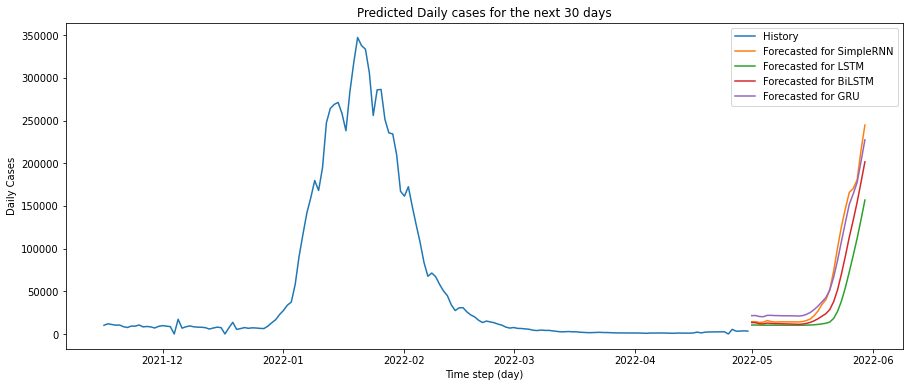

In [53]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,30)